# Домашнее задание 9

Возьмите готовую модель из https://huggingface.co/models для классификации сентимента текста.

Сделайте предсказания на всем df_val. Посчитайте метрику качества.

Дообучите эту модель на df_train. Посчитайте метрику качества на df_val.

In [1]:
!pip install transformers

**Импорты**

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import transformers
from transformers import pipeline
from transformers import BertTokenizer, BertForSequenceClassification

Загрузка данныех

In [5]:
!wget 'https://drive.google.com/uc?export=download&id=1Mev_EEput0LlBj8MDHIJkBtahlJ6J901' -O data.zip

--2024-01-17 11:54:39--  https://drive.google.com/uc?export=download&id=1Mev_EEput0LlBj8MDHIJkBtahlJ6J901
Resolving drive.google.com (drive.google.com)... 108.177.120.102, 108.177.120.101, 108.177.120.100, ...
Connecting to drive.google.com (drive.google.com)|108.177.120.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Mev_EEput0LlBj8MDHIJkBtahlJ6J901&export=download [following]
--2024-01-17 11:54:39--  https://drive.usercontent.google.com/download?id=1Mev_EEput0LlBj8MDHIJkBtahlJ6J901&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 209.85.145.132, 2607:f8b0:4001:c1e::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|209.85.145.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10733963 (10M) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]  10.24M  40.5MB/s  

In [6]:
!unzip data.zip

Archive:  data.zip
  inflating: train.csv               
  inflating: val.csv                 


In [7]:
df_train = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")

df_train.shape, df_val.shape

((181467, 3), (22683, 3))

In [8]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


Загрузка готовой [модели](https://huggingface.co/s-nlp/russian_toxicity_classifier)

Краткое опписание модели:

Классификатор на основе Берта (точно настроенный на основе разговорного Руберта ), обученный на слиянии набора данных о токсичных комментариях на русском языке , собранного с 2ch.hk, и набора данных о токсичных русских комментариях , собранного с ok.ru.

Наборы данных были объединены, перетасованы и разделены на части для обучения, разработки и тестирования в пропорции 80-10-10. Метрики, полученные из тестового набора данных, следующие:

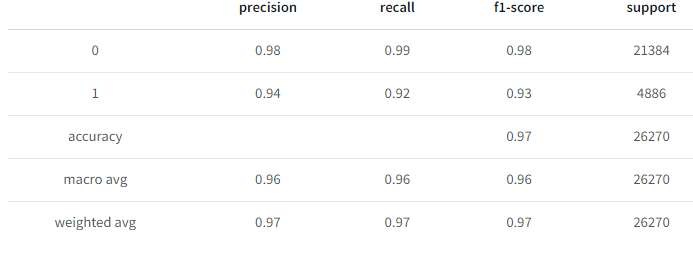


In [9]:
model_bert = BertForSequenceClassification.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
print(model_bert)
print("Parameters full train:", sum([param.nelement() for param in model_bert.parameters()]))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

**Пример классификации сентимента текста**

In [10]:
sentiment = pipeline("text-classification", model='SkolkovoInstitute/russian_toxicity_classifier')
sentiment("Этот ресторан отличный")

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'neutral', 'score': 0.998418927192688}]

**Пример работы токенизации**

In [11]:
tokenizer = BertTokenizer.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')

example_text = 'Пример текста для токенизации'

bert_input = tokenizer(example_text, padding='max_length', max_length=10,
                       truncation=True, return_tensors="pt")

print(bert_input['input_ids'])
print(bert_input['attention_mask'])

tensor([[  101, 17863, 10316,   949, 15427,   831,  2703,   102,     0,     0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [12]:
tokenizer.ids_to_tokens[101], tokenizer.ids_to_tokens[17863], tokenizer.ids_to_tokens[10316]

('[CLS]', 'Пример', 'текста')

In [13]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] Пример текста для токенизации [SEP] [PAD] [PAD]


In [14]:
sentiment = pipeline("text-classification", model='SkolkovoInstitute/russian_toxicity_classifier')

idx = 0
print(df_train.iloc[idx]['text'])
print('label is', df_train.iloc[idx]['class'])
print('label by model is', sentiment(df_train.iloc[idx]['text'])[0]['label'], 'with score', sentiment(df_train.iloc[idx]['text'])[0]['score'])

@alisachachka не уезжаааааааай. :(❤ я тоже не хочу, чтобы ты уезжала.
label is 0
label by model is neutral with score 0.9937475919723511


Dataset и Dataloader

In [15]:
class TwitterDataset(torch.utils.data.Dataset):

    def __init__(self, txts, labels):
        self._labels = labels

        self.tokenizer = BertTokenizer.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')

        self._txts = [self.tokenizer(text, padding='max_length', max_length=10,
                                     truncation=True, return_tensors="pt")
                      for text in txts]

    def __len__(self):
        return len(self._txts)

    def __getitem__(self, index):
        return self._txts[index], self._labels[index]

In [17]:
y_train = df_train['class'].values
y_val = df_val['class'].values

train_dataset = TwitterDataset(df_train['text'], y_train)
valid_dataset = TwitterDataset(df_val['text'], y_val)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=64,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=64,
                          shuffle=False,
                          num_workers=1)

In [18]:
for txt, lbl in train_loader:
    print(txt.keys()) #словарь с ключами'input_ids', 'token_type_ids', 'attention_mask'
    print(txt['input_ids'].shape) #тензор размера (B,1,max_len) из id токенов
    print(txt['attention_mask'].shape) #тензор размера (B,1,max_len) из индексов, указывающих, на какие токеты модель должна обратить внимание
    break

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
torch.Size([64, 1, 10])
torch.Size([64, 1, 10])


In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [34]:
model = BertForSequenceClassification.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier').to(device)
print(model)
print("Parameters full train:", sum([param.nelement() for param in model.parameters()]))
print("Parameters transfer learning:", sum([param.nelement() for param in model.classifier.parameters()]))

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.classifier.parameters(), lr=0.001)
epochs = 10

In [44]:
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    model.train()
    for train_input, train_label in tqdm(train_loader):
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)
        train_label = train_label.to(device)

        output = model(input_id, mask)[0]

        batch_loss = criterion(output, train_label)
        total_loss_train += batch_loss.item()

        acc = (output.argmax(dim=1) == train_label).sum().item()
        total_acc_train += acc

        model.zero_grad()
        batch_loss.backward()
        optimizer.step()
    model.eval()
    total_loss_val, total_acc_val = 0.0, 0.0
    for val_input, val_label in valid_loader:
        val_label = val_label.to(device)
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)[0]

        batch_loss = criterion(output, val_label)
        total_loss_val += batch_loss.item()

        acc = (output.argmax(dim=1) == val_label).sum().item()
        total_acc_val += acc
    print(
        f'Epochs: {epoch + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} \
        | Train Accuracy: {total_acc_train / len(train_dataset): .3f} \
        | Val Loss: {total_loss_val / len(valid_dataset): .3f} \
        | Val Accuracy: {total_acc_val / len(valid_dataset): .3f}')

100%|██████████| 2836/2836 [04:54<00:00,  9.64it/s]


Epochs: 1 | Train Loss:  0.010         | Train Accuracy:  0.589         | Val Loss:  0.010         | Val Accuracy:  0.615


100%|██████████| 2836/2836 [04:55<00:00,  9.60it/s]


Epochs: 2 | Train Loss:  0.010         | Train Accuracy:  0.595         | Val Loss:  0.011         | Val Accuracy:  0.585


100%|██████████| 2836/2836 [04:55<00:00,  9.61it/s]


Epochs: 3 | Train Loss:  0.010         | Train Accuracy:  0.593         | Val Loss:  0.011         | Val Accuracy:  0.602


100%|██████████| 2836/2836 [04:55<00:00,  9.61it/s]


Epochs: 4 | Train Loss:  0.010         | Train Accuracy:  0.596         | Val Loss:  0.010         | Val Accuracy:  0.609


100%|██████████| 2836/2836 [04:55<00:00,  9.60it/s]


Epochs: 5 | Train Loss:  0.010         | Train Accuracy:  0.595         | Val Loss:  0.010         | Val Accuracy:  0.615


100%|██████████| 2836/2836 [04:55<00:00,  9.61it/s]


Epochs: 6 | Train Loss:  0.010         | Train Accuracy:  0.594         | Val Loss:  0.010         | Val Accuracy:  0.612


100%|██████████| 2836/2836 [04:54<00:00,  9.62it/s]


Epochs: 7 | Train Loss:  0.010         | Train Accuracy:  0.595         | Val Loss:  0.010         | Val Accuracy:  0.611


100%|██████████| 2836/2836 [04:54<00:00,  9.62it/s]


Epochs: 8 | Train Loss:  0.010         | Train Accuracy:  0.595         | Val Loss:  0.010         | Val Accuracy:  0.622


100%|██████████| 2836/2836 [04:55<00:00,  9.58it/s]


Epochs: 9 | Train Loss:  0.010         | Train Accuracy:  0.596         | Val Loss:  0.010         | Val Accuracy:  0.607


100%|██████████| 2836/2836 [04:55<00:00,  9.61it/s]


Epochs: 10 | Train Loss:  0.010         | Train Accuracy:  0.595         | Val Loss:  0.010         | Val Accuracy:  0.619


In [45]:
df_train = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")

df_train.shape, df_val.shape

((181467, 3), (22683, 3))

In [46]:
df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_val['text'] = df_val['text'].apply(lambda x: x.lower())

In [47]:
y_train = df_train['class'].values
y_val = df_val['class'].values

train_dataset = TwitterDataset(df_train['text'], y_train)
valid_dataset = TwitterDataset(df_val['text'], y_val)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=64,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=64,
                          shuffle=False,
                          num_workers=1)

In [48]:
for txt, lbl in train_loader:
    print(txt.keys())
    print(txt['input_ids'].shape)
    break

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
torch.Size([64, 1, 10])


In [49]:
model2 = BertForSequenceClassification.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier').to(device)
print(model2)
print("Parameters full train:", sum([param.nelement() for param in model.parameters()]))
print("Parameters transfer learning:", sum([param.nelement() for param in model.classifier.parameters()]))

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.classifier.parameters(), lr=0.001)
epochs = 2

In [52]:
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    model.train()
    for train_input, train_label in tqdm(train_loader):
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)
        train_label = train_label.to(device)

        output = model(input_id, mask)[0]

        batch_loss = criterion(output, train_label)
        total_loss_train += batch_loss.item()

        acc = (output.argmax(dim=1) == train_label).sum().item()
        total_acc_train += acc

        model.zero_grad()
        batch_loss.backward()
        optimizer.step()
    model.eval()
    total_loss_val, total_acc_val = 0.0, 0.0
    for val_input, val_label in valid_loader:
        val_label = val_label.to(device)
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)[0]

        batch_loss = criterion(output, val_label)
        total_loss_val += batch_loss.item()

        acc = (output.argmax(dim=1) == val_label).sum().item()
        total_acc_val += acc
    print(
        f'Epochs: {epoch + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} \
        | Train Accuracy: {total_acc_train / len(train_dataset): .3f} \
        | Val Loss: {total_loss_val / len(valid_dataset): .3f} \
        | Val Accuracy: {total_acc_val / len(valid_dataset): .3f}')

100%|██████████| 2836/2836 [04:52<00:00,  9.70it/s]


Epochs: 1 | Train Loss:  0.011         | Train Accuracy:  0.582         | Val Loss:  0.010         | Val Accuracy:  0.616


100%|██████████| 2836/2836 [04:55<00:00,  9.60it/s]


Epochs: 2 | Train Loss:  0.011         | Train Accuracy:  0.585         | Val Loss:  0.010         | Val Accuracy:  0.620
